In [1]:
import os
import string
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from collections import Counter


In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        for param in resnet.parameters():
            param.requires_grad_(False)
        modules = list(resnet.children())[:-1]  # remove final fc layer
        self.resnet = nn.Sequential(*modules)
        self.fc = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.fc(features))
        return features


In [3]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.3)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions[:, :-1]))
        inputs = torch.cat((features.unsqueeze(1), embeddings), 1)
        hiddens, _ = self.lstm(inputs)
        outputs = self.linear(hiddens)
        return outputs

    def sample(self, features, max_len=20):
        output_ids = []
        states = None
        inputs = features.unsqueeze(1)
        for _ in range(max_len):
            hiddens, states = self.lstm(inputs, states)
            outputs = self.linear(hiddens.squeeze(1))
            predicted = outputs.argmax(1)
            output_ids.append(predicted.item())
            inputs = self.embed(predicted).unsqueeze(1)
        return output_ids


In [4]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions, vocab, transform=None):
        self.root_dir = root_dir
        self.captions = captions  # list of (image_name, caption)
        self.vocab = vocab
        self.transform = transform

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        img_name, caption = self.captions[idx]
        image = Image.open(os.path.join(self.root_dir, img_name)).convert("RGB")
        if self.transform:
            image = self.transform(image)

        numerical_caption = [self.vocab["<start>"]] + \
            [self.vocab.get(word, self.vocab["<unk>"]) for word in caption.split()] + \
            [self.vocab["<end>"]]

        return image, torch.tensor(numerical_caption)


In [5]:
def build_vocab(captions_list, freq_threshold=5):
    counter = Counter()
    for _, caption in captions_list:
        counter.update(caption.split())

    words = [w for w, c in counter.items() if c >= freq_threshold]
    vocab = {"<pad>": 0, "<start>": 1, "<end>": 2, "<unk>": 3}
    for idx, word in enumerate(words, 4):
        vocab[word] = idx
    return vocab


In [6]:
import csv
if __name__ == "__main__":
    # === Load captions file ===
    captions_list = []
    torch.cuda.set_device(1)
    with open("data/captions.txt", "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)  # automatically skips the header
        for row in reader:
            img = row["image"].strip()
            caption = row["caption"].strip().lower()
            captions_list.append((img, caption))

    print(len(captions_list))
    # === Build vocabulary ===
    vocab = build_vocab(captions_list)
    vocab_size = len(vocab)
    print(f"✅ Vocabulary size: {vocab_size}")

    # === Dataset & Dataloader ===
    dataset = FlickrDataset(
        root_dir="data/images/",
        captions=captions_list,
        vocab=vocab,
        transform=transform
    )

    # print(dataset.__len__())

    def collate_fn(batch):
        images = torch.stack([img for img, _ in batch])
        captions = [cap for _, cap in batch]
        captions = torch.nn.utils.rnn.pad_sequence(captions, batch_first=True)
        return images, captions

    dataloader = DataLoader(dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)

    # === Device ===
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # === Models ===
    embed_size = 256
    hidden_size = 512
    lstm_layers = 1

    encoder = EncoderCNN(embed_size).to(device)
    decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers=lstm_layers).to(device)

    # === Loss & Optimizer ===
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # ignore <pad>
    params = list(decoder.parameters()) + list(encoder.fc.parameters()) + list(encoder.bn.parameters())
    optimizer = torch.optim.Adam(params, lr=1e-3)

    # === Training Loop ===
    num_epochs = 10  # keep small for testing

    for epoch in range(num_epochs):
        # encoder.train()
        decoder.train()
        total_loss = 0

        for images, captions in dataloader:
            images, captions = images.to(device), captions.to(device)

            optimizer.zero_grad()
            features = encoder(images)

            outputs = decoder(features, captions[:, :-1])
            targets = captions[:, 1:]

            loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")

    # === Save Models ===
    torch.save({
        "encoder": encoder.state_dict(),
        "decoder": decoder.state_dict(),
        "vocab": vocab
    }, "caption_model.pth")

    print("✅ Training complete. Model saved as caption_model.pth.")


40455
✅ Vocabulary size: 3005
Using device: cuda
Epoch [1/10] Loss: 4.1116
Epoch [2/10] Loss: 3.4864
Epoch [3/10] Loss: 3.2428
Epoch [4/10] Loss: 3.0745
Epoch [5/10] Loss: 2.9378
Epoch [6/10] Loss: 2.8213
Epoch [7/10] Loss: 2.7190
Epoch [8/10] Loss: 2.6257
Epoch [9/10] Loss: 2.5437
Epoch [10/10] Loss: 2.4682
✅ Training complete. Model saved as caption_model.pth.


In [7]:
# plotting loss after

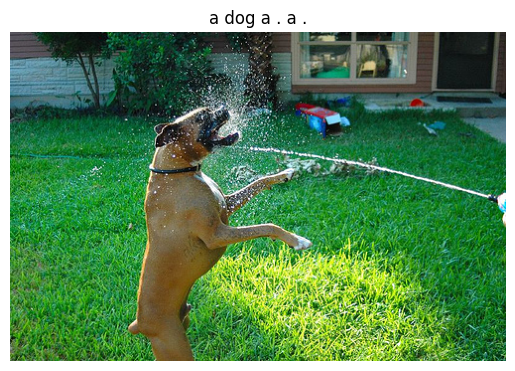

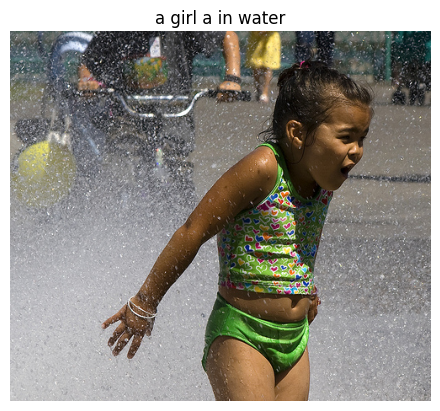

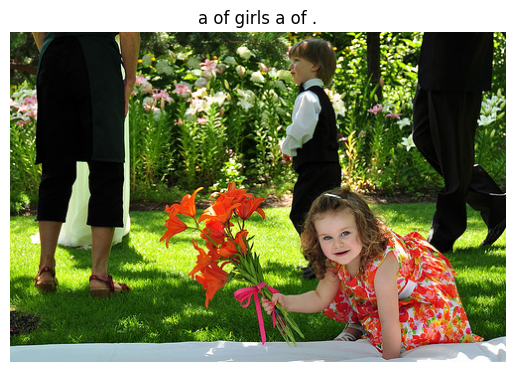

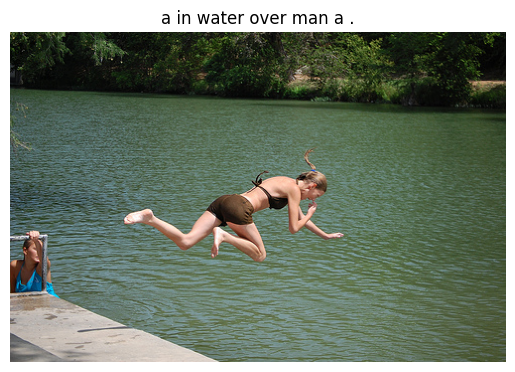

In [8]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image

# === Load checkpoint ===
checkpoint = torch.load("caption_model.pth", map_location=device)
encoder.load_state_dict(checkpoint["encoder"])
decoder.load_state_dict(checkpoint["decoder"])
vocab = checkpoint["vocab"]  # assuming vocab is a dict: word -> idx
idx2word = {idx: word for word, idx in vocab.items()}  # reverse lookup

encoder.eval()
decoder.eval()

# === Caption generation function ===
def generate_caption(image, encoder, decoder, idx2word, max_len=20):
    with torch.no_grad():
        features = encoder(image.unsqueeze(0).to(device))
        output_ids = decoder.sample(features, max_len)
        # convert ids to words, stop at <end> token
        caption_words = []
        for idx in output_ids:
            word = idx2word[idx]
            if word == "<end>":
                break
            if word != "<start>":  # skip <start> token
                caption_words.append(word)
        caption = " ".join(caption_words)
        return caption

# === Define transform for test images ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

# === Visualize a few test images ===
test_images = ["data/images/44856031_0d82c2c7d1.jpg", "data/images/3765374230_cb1bbee0cb.jpg", "data/images/3760400645_3ba51d27f9.jpg", "data/images/3758787457_1a903ee1e9.jpg"]

for img_path in test_images:
    image = Image.open(img_path).convert("RGB")
    input_image = transform(image)
    caption = generate_caption(input_image, encoder, decoder, idx2word)

    plt.imshow(image)
    plt.axis("off")
    plt.title(caption)
    plt.show()


In [2]:
# === Évaluation avec BLEU-1 (sacrebleu) et BERTScore ===
import csv
import numpy as np
from collections import defaultdict
import sacrebleu
from bert_score import score as bert_score
import torch
from PIL import Image
from torchvision import transforms

device = "cuda"

# 1. Charger le modèle pour la génération
checkpoint = torch.load("caption_model.pth", map_location=device)
vocab = checkpoint["vocab"]
vocab_size = len(vocab)
idx2word = {idx: word for word, idx in vocab.items()}

embed_size = 256
hidden_size = 512

encoder.load_state_dict(checkpoint["encoder"])
decoder.load_state_dict(checkpoint["decoder"])

encoder.eval()
decoder.eval()

print("✅ Modèle chargé pour l'évaluation")

# 2. Charger toutes les captions de référence par image
image_captions = defaultdict(list)
with open("data/captions.txt", "r", encoding="utf-8") as f:
    reader = csv.DictReader(f)
    for row in reader:
        img = row["image"].strip()
        caption = row["caption"].strip().lower()
        image_captions[img].append(caption)

print(f"✅ {len(image_captions)} images avec leurs captions de référence chargées")

# 3. Fonction de génération de caption
def generate_caption(image_path, encoder, decoder, idx2word, transform, max_len=20):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        features = encoder(image_tensor)
        output_ids = decoder.sample(features, max_len)
        
    caption_words = []
    for idx in output_ids:
        word = idx2word.get(idx, "<unk>")
        if word == "<end>":
            break
        if word not in ["<start>", "<pad>"]:
            caption_words.append(word)
    
    return " ".join(caption_words)

# 4. Évaluation sur un échantillon d'images
transform_eval = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

# Prendre un échantillon d'images (par exemple 100)
sample_images = list(image_captions.keys())[:100]

bleu1_scores = []
bertscore_precision = []
bertscore_recall = []
bertscore_f1 = []

print("\n📊 Début de l'évaluation...")

for idx, img_name in enumerate(sample_images, 1):
    img_path = f"data/Images/{img_name}"
    
    # Générer la caption
    generated_caption = generate_caption(img_path, encoder, decoder, idx2word, transform_eval)
    
    # Références (toutes les captions pour cette image)
    reference_captions = image_captions[img_name]
    
    # === BLEU-1 Score (sacrebleu) ===
    bleu1 = sacrebleu.corpus_bleu(
        [generated_caption],  # Hypothèse
        [reference_captions],  # Références
        force=True,
        lowercase=True,
        smooth_method='exp'
    ).score / 100.0  # sacrebleu renvoie un score sur 0-100
    bleu1_scores.append(bleu1)
    
    # === BERTScore ===
    P, R, F1 = bert_score([generated_caption]*len(reference_captions),
                          reference_captions, lang="en", verbose=False)
    bertscore_precision.append(P.mean().item())
    bertscore_recall.append(R.mean().item())
    bertscore_f1.append(F1.mean().item())
    
    if idx % 10 == 0:
        print(f"✓ Évalué {idx} images...")

# 5. Résultats finaux
print("\n" + "="*60)
print("📈 RÉSULTATS D'ÉVALUATION")
print("="*60)
print(f"\n🔹 BLEU-1 Score:")
print(f"   Moyenne: {np.mean(bleu1_scores):.4f}")
print(f"   Écart-type: {np.std(bleu1_scores):.4f}")
print(f"   Min: {np.min(bleu1_scores):.4f}")
print(f"   Max: {np.max(bleu1_scores):.4f}")

print(f"\n🔹 BERTScore F1:")
print(f"   Moyenne: {np.mean(bertscore_f1):.4f}")
print(f"   Écart-type: {np.std(bertscore_f1):.4f}")
print(f"   Min: {np.min(bertscore_f1):.4f}")
print(f"   Max: {np.max(bertscore_f1):.4f}")

print(f"\n🔹 BERTScore Precision:")
print(f"   Moyenne: {np.mean(bertscore_precision):.4f}")

print(f"\n🔹 BERTScore Recall:")
print(f"   Moyenne: {np.mean(bertscore_recall):.4f}")

# 6. Exemple détaillé pour une image
example_img = sample_images[0]
example_path = f"data/Images/{example_img}"
generated = generate_caption(example_path, encoder, decoder, idx2word, transform_eval)
references = image_captions[example_img]

print(f"\n📸 Exemple détaillé pour {example_img}:")
print(f"\n   Caption générée: {generated}")
print(f"\n   Captions de référence:")
for i, ref in enumerate(references, 1):
    print(f"      {i}. {ref}")

# BLEU-1 détaillé avec sacrebleu
bleu1_detailed = [sacrebleu.corpus_bleu([generated], [[ref]], 
                                        force=True, lowercase=True, smooth_method='exp').score / 100.0
                  for ref in references]
    
print(f"\n   BLEU-1 par référence: {[f'{b:.4f}' for b in bleu1_detailed]}")
print(f"   BLEU-1 moyenne: {np.mean(bleu1_detailed):.4f}")
print(f"   BLEU-1 variance: {np.var(bleu1_detailed):.4f}")


/tmp/ipykernel_41356/4253995414.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("caption_model.pth", map_location=device)


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.